# Titanic Competition

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### Import libraries

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

### Read Data

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


### Exploratory Data Analysis

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Data Wrangling

In [7]:
# Replace NA value by 'Age' mean and 'Embarked' mode.
train['Age'].fillna(train['Age'].mean(), inplace = True)
test['Age'].fillna(test['Age'].mean(), inplace = True)

# Replace NA value by 'Embarked' mode.
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace = True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace = True)

In [8]:
# 'Cabin' still needs to be adjusted.
# We decided to delete this feature, since there are too many null values.
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [9]:
# Drop "PassengerId", "Fare", "Name", "Ticket","Cabin" columns in the train set.
train.drop(["PassengerId", "Fare", "Name", "Ticket","Cabin"], axis=1, inplace=True)

# We don't drop "PassengerId" column in the test set, because we'll need for submition.
test.drop(["Fare", "Name", "Ticket","Cabin"], axis=1, inplace=True)

### Data Visualization

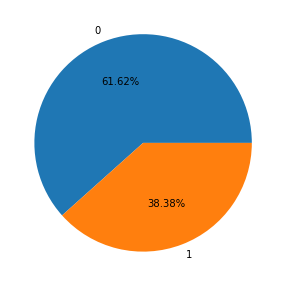

In [10]:
values = train['Survived'].value_counts() # Count the unique values of 'Survided' column
labels = train['Survived'].unique() # Extract unique values of 'Survided' column (0 and 1)

# Pie Chart: 0 for Died and 1 for Survived
fig, ax = plt.subplots(figsize = (10,5))
ax.pie(values, labels=labels, autopct='%1.2f%%')
plt.show()

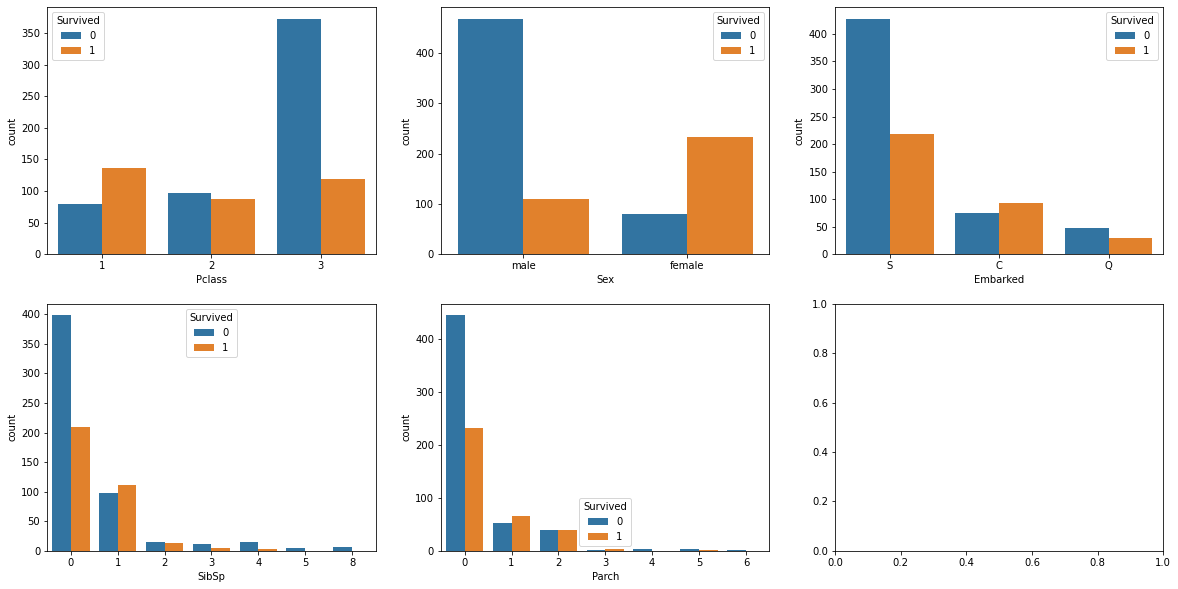

In [11]:
fig, axs = plt.subplots(2, 3, figsize = (20,10))
sns.countplot(ax=axs[0, 0], x=train['Pclass'], hue=train['Survived'])
sns.countplot(ax=axs[0, 1], x=train['Sex'], hue=train['Survived'])
sns.countplot(ax=axs[0, 2], x=train['Embarked'], hue=train['Survived'])
sns.countplot(ax=axs[1, 0], x=train['SibSp'], hue=train['Survived'])
sns.countplot(ax=axs[1, 1], x=train['Parch'], hue=train['Survived'])
#sns.countplot(ax=axs[1, 2], x=train['Cabin'].str[0:1].values, hue=train['Survived'])
plt.show()

In [12]:
# Create a column with 0 and 1 for Male and Not Male (or female).
train['Male'] = pd.get_dummies(train['Sex'])['male']
test['Male'] = pd.get_dummies(test['Sex'])['male']

In [13]:
# Drop 'Sex' columns, since we created the 'Male' column.
train.drop(["Sex"], axis=1, inplace=True)
test.drop(["Sex"], axis=1, inplace=True)

In [14]:
# Create columns for each port except.
train['Cherbourg'] = pd.get_dummies(train['Embarked'])['C']
train['Queenstown'] = pd.get_dummies(train['Embarked'])['Q']

# Drop 'Embarked', since we created columns for the ports.
train.drop(["Embarked"], axis=1, inplace=True)

In [15]:
# Create columns for each port except.
test['Cherbourg'] = pd.get_dummies(test['Embarked'])['C']
test['Queenstown'] = pd.get_dummies(test['Embarked'])['Q']

# Drop 'Embarked', since we created columns for the ports.
test.drop(["Embarked"], axis=1, inplace=True)

In [16]:
# Split features and labels.
X = train.drop('Survived', axis=1)
Y = train['Survived']

In [17]:
# Split Train ans Test for modeling.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

In [18]:
# Create a list of models we intend to 
models = [('Logistic Regression', LogisticRegression()),
         ('KNN', KNeighborsClassifier()),
         ('Decision Tree', DecisionTreeClassifier()),
         ('Random Forest', RandomForestClassifier()),
         ('Ada Boost', AdaBoostClassifier()),
         ('XGB', XGBClassifier()),
         ('Support Vector', SVC()),
         ('Gaussian Naive Bayes', GaussianNB())]

In [19]:
for name, model in models:
    model.fit(x_train, y_train)
    y_hat = model.predict(x_train)
    Acc_train = accuracy_score(y_train, y_hat)
    y_hat2 = model.predict(x_test)
    Acc_test = accuracy_score(y_test, y_hat2)
    print(f'{name} Train Accuracy: {Acc_train} \n{name} Test Accuracy: {Acc_test} \n')

Logistic Regression Train Accuracy: 0.7949438202247191 
Logistic Regression Test Accuracy: 0.8268156424581006 

KNN Train Accuracy: 0.8230337078651685 
KNN Test Accuracy: 0.8379888268156425 

Decision Tree Train Accuracy: 0.9396067415730337 
Decision Tree Test Accuracy: 0.8156424581005587 

Random Forest Train Accuracy: 0.9396067415730337 
Random Forest Test Accuracy: 0.8324022346368715 

Ada Boost Train Accuracy: 0.8202247191011236 
Ada Boost Test Accuracy: 0.8268156424581006 

XGB Train Accuracy: 0.9157303370786517 
XGB Test Accuracy: 0.8268156424581006 

Support Vector Train Accuracy: 0.6292134831460674 
Support Vector Test Accuracy: 0.6815642458100558 

Gaussian Naive Bayes Train Accuracy: 0.7752808988764045 
Gaussian Naive Bayes Test Accuracy: 0.8324022346368715 



In [20]:
random = RandomForestClassifier()
random.fit(x_train, y_train)

RandomForestClassifier()

In [21]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Male,Cherbourg,Queenstown
0,892,3,34.5,0,0,1,0,1
1,893,3,47.0,1,0,0,0,0
2,894,2,62.0,0,0,1,0,1
3,895,3,27.0,0,0,1,0,0
4,896,3,22.0,1,1,0,0,0


In [22]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Male,Cherbourg,Queenstown
0,0,3,22.0,1,0,1,0,0
1,1,1,38.0,1,0,0,1,0
2,1,3,26.0,0,0,0,0,0
3,1,1,35.0,1,0,0,0,0
4,0,3,35.0,0,0,1,0,0


In [23]:
submit = test.drop(['PassengerId'], axis=1)

In [24]:
submit.head()

,Pclass,Age,SibSp,Parch,Male,Cherbourg,Queenstown
0,3,34.5,0,0,1,0,1
1,3,47.0,1,0,0,0,0
2,2,62.0,0,0,1,0,1
3,3,27.0,0,0,1,0,0
4,3,22.0,1,1,0,0,0


In [25]:
submit['Survived'] = random.predict(submit)

In [26]:
submit.head()

,Pclass,Age,SibSp,Parch,Male,Cherbourg,Queenstown,Survived
0,3,34.5,0,0,1,0,1,0
1,3,47.0,1,0,0,0,0,0
2,2,62.0,0,0,1,0,1,0
3,3,27.0,0,0,1,0,0,1
4,3,22.0,1,1,0,0,0,0


In [27]:
submit['PassengerId'] = test['PassengerId']

In [28]:
submit.drop(['Pclass', 'Age', 'SibSp', 'Parch', 'Male', 'Cherbourg', 'Queenstown'], axis=1, inplace=True)

In [29]:
submit.head(10)

,Survived,PassengerId
0,0,892
1,0,893
2,0,894
3,1,895
4,0,896
5,0,897
6,1,898
7,0,899
8,0,900
9,0,901


In [30]:
submit = submit[['PassengerId', 'Survived']]

In [31]:
submit.to_csv('submission.csv', index=False)